# Step 3: Generate terminus position timeseries along flowlines

_Last modified 2022-07-01._


This script is run after the WTMM analysis is complete in order to extract terminus positions from the automated delinations. Relative terminus positions are calculated along three glacier flowlines, created automatically using the glacier terminus box.

The code is streamlined to analyze images for hundreds of glaciers, specifically, the marine-terminating glaciers along the periphery of Greenland. For use on other glaciers, sections of code must be modified:

    ##########################################################################################

    code to modify

    ##########################################################################################

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pylab as pl
import os
import subprocess
import shutil
import fiona
from shapely.geometry import Polygon, Point
import shapely
import cv2
import json
import scipy.stats
import datetime
import math
from multiprocessing import Pool

# import necessary functions from automated-glacier-terminus.py
from automated_terminus_functions import *

# 1) Grab the BoxIDs for the glaciers

In [25]:
# Use one of the csv files to grab multiple glacier BoxIDs
VEL_FILENAME = 'Glacier_vel_'+csvext # name of velocity file generated in preprocess.ipynb Step 7
velocities_df = pd.read_csv(csvpath+VEL_FILENAME, sep=',', dtype=str)
velocities_df = velocities_df.set_index('BoxID')
BoxIDs = list(velocities_df.index)
BoxID
print(BoxIDs)

['Funk', 'Drummond']


# 2) Generate the terminus position time series

In [63]:
# ######################################################################################
path = '/Volumes/SGlacier/auto-terminus-traces/Antarctic-test/LSaws/' # path to the processed images
csvext = 'Antarctic-test.csv' # name of csv ext used in preprocessing script

# CSV files generated during pre-processing
csvpath = '/Volumes/SGlacier/auto-terminus-traces/Antarctic-test/'
DATES_FILENAME = 'imgdates_'+csvext
FLINE_FILENAME = 'Boxes_flowlinecoords_'+csvext
VEL_FILENAME = 'Glacier_vel_'+csvext
filedate = '2024_04_29' # date that you ran the WTMM terminus picking (in the terminus pick file name)

# These are the recommended values used for time series filtering
V = 3 # flow speed scalar multiplier (increase to filter more, decrease to filter less)
N1 = 1 # number of iterations to remove dips (sudden drop below average)
N2 = 1 # number of iterations to remove jumps (sudden jump above average)
# ######################################################################################

## 2A) Generate terminus positions using results produced with python wtmm2d:

In [64]:
# read in csv files
datetime_df = pd.read_csv(csvpath+DATES_FILENAME, sep=',', # IMAGE DATES
                          dtype=str, header=0, names=['Scene', 'datetimes'])
    
centerline_df = pd.read_csv(csvpath+FLINE_FILENAME, sep=',', # CENTERLINE INFO
                            dtype=str, header=0); centerline_df = centerline_df.set_index('BoxID')

flowspeed_df= pd.read_csv(csvpath+VEL_FILENAME, sep=',', # GLACIER VELOCITIES
                          dtype=str); flowspeed_df = flowspeed_df.set_index('BoxID')
print('CSV files loaded.')

CSV files loaded.


In [65]:
######################### set BoxIDs ################################################# 
BoxIDs = ['Funk'] # enter BoxIDs
# BoxIDs = list(centerline_df.index) # read from flowline file
print(BoxIDs)
######################################################################################

['Funk']


In [66]:
def get_results(BOI):
    print("Box"+BOI)
    chainpath = path+'Box'+BOI+'/'+rotated_foldername
    
    # remove empty chain folders           
    for file in os.listdir(chainpath):
        if file.endswith('chains'):
            # remove empty chain folders
            if len(os.listdir(chainpath+file)) == 0:
                os.rmdir(chainpath+file)
    
    # LOAD IN TERMINUS PICK FILE
    termpick_df = pd.read_csv(csvpath+'terminuspicks_Box'+BOI+'_'+filedate+'.csv')
    
    #CALCULATE TERMINUS POSITIONS
    # LOAD IN REFERENCE POINTS to calculate terminus position with respect to
    box_midpoint_x = float(centerline_df.loc[BOI, 'lmid50_x']); box_midpoint_y = float(centerline_df.loc[BOI, 'lmid50_y'])
    boxmid_x_25 = float(centerline_df.loc[BOI, 'lmid25_x']); boxmid_y_25 = float(centerline_df.loc[BOI, 'lmid25_y'])
    boxmid_x_75 = float(centerline_df.loc[BOI, 'lmid75_x']); boxmid_y_75 = float(centerline_df.loc[BOI, 'lmid75_y'])

    #GRAB CENTERLINE POINTS
    #grab slopes and intercepts from the dataframe
    c_slope = float(centerline_df.loc[BOI]['m50']); c_intercept = float(centerline_df.loc[BOI]['b50']) 
    c25_slope = float(centerline_df.loc[BOI]['m25']); c25_intercept = float(centerline_df.loc[BOI]['b25'])
    c75_slope = float(centerline_df.loc[BOI]['m75']); c75_intercept = float(centerline_df.loc[BOI]['b75'])  

    #grab range of x-values
    xmin50 = float(box_midpoint_x); xmax50 = float(centerline_df.loc[BOI, 'rmid50_x']); ymid50 = float(box_midpoint_y)
    xmin25 = float(boxmid_x_25); xmax25 = float(centerline_df.loc[BOI, 'rmid25_x']); ymid25 = float(boxmid_y_25)
    xmin75 = float(boxmid_x_75); xmax75 = float(centerline_df.loc[BOI, 'lmid75_x']); ymid75 = float(boxmid_y_75)
    xmax = np.max([xmax50, xmax25, xmax75]); xmin = np.min([xmin50, xmin25, xmin75]); c_x = np.linspace(xmin, xmax, int(xmax-xmin)*2)

    #calculate y-values using the various centerlines
    c_y = c_slope*c_x + c_intercept; c_y_25 = c25_slope*c_x + c25_intercept; c_y_75 = c75_slope*c_x + c75_intercept

    # LISTS TO HOLD TERMINUS POSITIONS AND INTERSECTION POINTS
    terminus_positions = []; tpositions_25 = []; tpositions_75 = []
    intersections = []; X25 = []; X75 = []
    
    for index, row in termpick_df.iterrows():
        intersect_xs = []; intersect_xs_25 = []; intersect_xs_75 = []
        intersect_ys = []; intersect_ys_25 = []; intersect_ys_75 = []
        scale = str(row['Scale']).zfill(3); scene = row['Scene']
        
        # read in chain jsons
        with open(chainpath+'R_'+scene+'_B8_Buffer'+BOI+'_chains/'+scale+'_chain.json') as f:
            data = json.load(f)
        dat_xs = np.array(data.get('ix')); dat_ys = np.array(data.get('iy'))
            
        for l in range(0, len(c_x)):
            x = c_x[l]; y = c_y[l]; y25 = c_y_25[l]; y75 = c_y_75[l]        
            interval = 0.8 # pixels between points
            for k in range(0, len(dat_xs)):
                dat_x = dat_xs[k]; dat_y = dat_ys[k]

                #midway centerline
                if within(dat_x, x, interval) and within(dat_y, y, interval):
                    intersect_xs.append(dat_x); intersect_ys.append(dat_y)  
                #1/4th centerline
                if within(dat_x, x, interval) and within(dat_y, y25, interval):
                    intersect_xs_25.append(dat_x); intersect_ys_25.append(dat_y)              
                #3/4th centerline
                if within(dat_x, x, interval) and within(dat_y, y75, interval):
                    intersect_xs_75.append(dat_x); intersect_ys_75.append(dat_y)
                    
        #for 50 centerline
        if len(intersect_xs) == 0: #if no intersections are found with the terminus line, append Nans to tpos
            tpos50 = np.NaN; intersect_x = np.NaN; intersect_y = np.NaN
        else: #if at least one is found:
            #intersection with the greatest x (use distance formula to calculate distance between)
            max_index = intersect_xs.index(np.max(intersect_xs))
            intersect_x = intersect_xs[max_index]; intersect_y = intersect_ys[max_index]
            tpos50 = (intersect_x-xmin50)*15.0

        #repeat for for 25 centerline
        if len(intersect_xs_25) == 0:
            tpos25 = np.NaN; intersect_x25 = np.NaN; intersect_y25 = np.NaN
        else:
            max_index_25 = intersect_xs_25.index(np.max(intersect_xs_25))
            intersect_x25 = intersect_xs_25[max_index_25]; intersect_y25 = intersect_ys_25[max_index_25]
            tpos25 = (intersect_x25-xmin25)*15.0

        #for 75 centerline
        if len(intersect_xs_75) == 0:
            tpos75 = np.NaN; intersect_x75 = np.NaN; intersect_y75 = np.NaN
        else:
            max_index_75 = intersect_xs_75.index(np.max(intersect_xs_75))
            intersect_x75 = intersect_xs_75[max_index_75]; intersect_y75 = intersect_ys_75[max_index_75]
            tpos75 = (intersect_x75-xmin75)*15.0

        #append to lists
        terminus_positions.append(tpos50); tpositions_25.append(tpos25); tpositions_75.append(tpos75)
        intersections.append([intersect_x, intersect_y]); X25.append([intersect_x25, intersect_y25]); 
        X75.append([intersect_x75, intersect_y75])            
    
    # ADD TERMINUS POSITION AND INTERSECTIONS TO THE DATAFRAME
    termpick_df['tpos50'] = terminus_positions; termpick_df['tpos25'] = tpositions_25; 
    termpick_df['tpos75'] = tpositions_75; termpick_df['X50'] = intersections;
    termpick_df['X25'] = X25; termpick_df['X75'] = X75

    # SPLIT INTO 3 DATAFRAMES FOR 3 FLOWLINES:
    df_50 = termpick_df[['Scene', 'BoxID', 'Scale', 'datetimes', 'Metric', 'Order', 
                                          'tpos50', 'X50',]].copy().reset_index(drop=True)
    df_50 = df_50.rename(columns={"tpos50": "tpos", "X50": "X"})
    df_25 = termpick_df[['Scene', 'BoxID', 'Scale', 'datetimes', 'Metric', 'Order', 
                                          'tpos25', 'X25']].copy().reset_index(drop=True)
    df_25 = df_25.rename(columns={"tpos25": "tpos", "X25": "X"})
    df_75 = termpick_df[['Scene', 'BoxID', 'Scale', 'datetimes', 'Metric', 'Order', 
                                          'tpos75', 'X75']].copy().reset_index(drop=True)
    df_75 = df_75.rename(columns={"tpos75": "tpos", "X75": "X"})
    dfs = [df_50, df_25, df_75] # make a list

    # CALCULATE TERMINUS CHANGE RATES
    dfs_new = []
    for df in dfs: 
        to_datetimes(df); dfs_new.append(calc_changerates1(df))

    #FILTER USING 5*MAXIMUM FLOW SPEEDS
    max_flow = float(flowspeed_df['Max_speed'][BOI])
    if max_flow < 1.0:
        flow_thresh = V
    else:
        flow_thresh = V*max_flow
    #remove dips
    nodips = []
    for df in dfs_new:
        nodips.append(remove_dips(df, flow_thresh, N1))
    #remove jumps 
    nojumps = []
    for df in nodips:
        nojumps.append(remove_jumps(df, flow_thresh, N2))
        
    #stop the process if there are no points remaining after filtering
    for df in nojumps:
        if len(df) == 0:
            continue

    #GRAB HIGHEST ORDER PICK AFTER FILTERING
    highestorder_dfs = []
    for df in nojumps:
        #grab unique dates
        unique_dates = set(list(df['datetimes']))
        #grab highest orders:
        order_list = []
        for date in unique_dates:
            date_df = df[df['datetimes'] == date].copy(); highestorder = np.min(np.array(date_df['Order']))
            order_list.append(highestorder)
        highestorder_df = pd.DataFrame(list(zip(unique_dates, order_list)), columns=['datetimes', 'Order']).sort_values(by='datetimes', ascending=True)
        highestorder_dfs.append(highestorder_df)

    onepick_dfs = []
    for i in range(0, len(highestorder_dfs)):
        onepick_df = nojumps[i].merge(highestorder_dfs[i], how='inner', on=['datetimes', 'Order'])
        onepick_dfs.append(onepick_df)

    #PLOT AND SAVE
    fig, ax1 = plt.subplots(figsize=(12,4))
    colors = pl.cm.viridis(np.linspace(0,0.5,3)) # generate 3 flowline colors using Dark2 scheme
    maxlen = 0; maxdf_idx = None
    for j in range(0, len(onepick_dfs)): # 3 dataframes, 1 for each flowline
        df = onepick_dfs[j]
        # plot:
        ax1.plot(df['datetimes'], df['tpos'], marker = 'o', linewidth=0, 
                 color=colors[j], markersize=5, alpha=0.7)

    #general plot parameters
    ax1.set_ylabel('Terminus position (m)', color='k', fontsize=12)
    ax1.set_title("Box"+BOI, fontsize=16); ax1.set_xlabel('Date', fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    #save figure
    plt.legend(['1/2', '1/4', '3/4'])
    if not os.path.exists(csvpath+'Figures/'):
        os.mkdir(csvpath+'Figures/')
    plt.savefig(csvpath+"Figures/Termposition_LS_m_Box"+BOI+"_"+filedate+".png", dpi=200)
    plt.show()

    # save the terminus position time series along tgethree flowlines
    flowlines = ['flowline50', 'flowline25', 'flowline75']
    for k in range(0, len(onepick_dfs)):
        df = onepick_dfs[k];
        df.to_csv(path_or_buf = csvpath+'Tpos_Box'+BOI+'_'+flowlines[k]+'_filtered_py.csv', sep=',')
        
        # save the final chains into the delineations folder
        for idx, row in df.iterrows():
            ip = processed_image_path+'Box'+BoxID+'/'+rotated_foldername
            ip += 'R_'+str(row.Scene)+'_B8_Buffer'+BoxID+'_chains/'
            ip += str(row.Scale).zfill(3)+'_chain.geojson' # name of the geojson file
            of = processed_image_path+'Box'+BoxID+'/delineations/'
            if not os.path.exists(of):
                os.mkdir(of)
            op = of+'Box'+BoxID+'_'+str(row.datetimes)[:10]+'_'+flowlines[k]+'.geojson'
            shutil.copyfile(ip, op)

### 2A.1) Option 1: Run in series (loop):

BoxFunk


/Users/jukesliu/Documents/GitHub/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange
/Users/jukesliu/Documents/GitHub/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange
/Users/jukesliu/Documents/GitHub/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Dropping 0 dips
Dropping 0 dips
Dropping 0 dips
Dropping 9 jumps
Dropping 7 jumps
Dropping 6 jumps


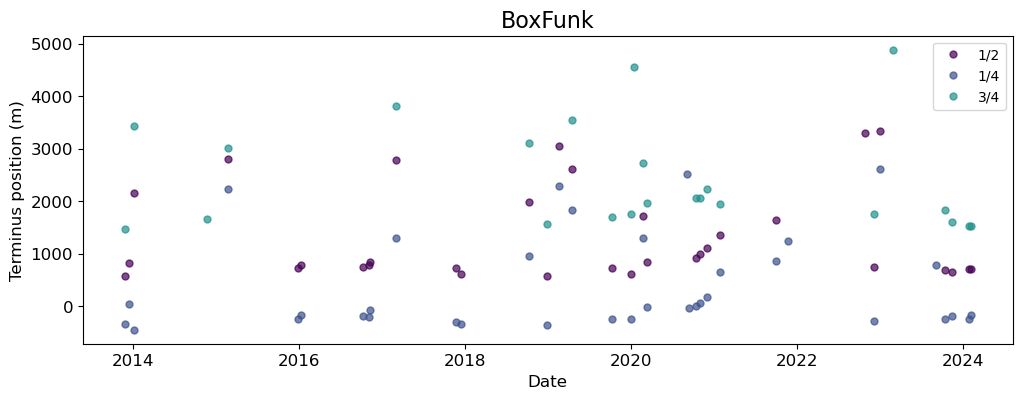

In [70]:
for BoxID in BoxIDs:
    get_results(BoxID)

### 2A.2) Option 2: Run in parallel (batches):

In [68]:
# check number of cpus on machine using os:
print(os.cpu_count(), 'CPUs on the machine')

################################################################################################
# set batch size accordingly
# recommendation is to leave one or two cpus available for other background processing
batch_size = 10
print('Batch size:',batch_size)
################################################################################################

16 CPUs on the machine
Batch size: 10


In [69]:
nbatches = int(np.ceil(len(BoxIDs)/batch_size)) # round up to the next batch size
nfullbatches = int(np.floor(len(BoxIDs)/batch_size)) # number of full batches
print(nbatches, 'batches')
print(nfullbatches, 'full batches')

1 batches
0 full batches


In [37]:
# full batches
for b in range(0, nfullbatches):
    pool = Pool() # initialize pool
    batchids = BoxIDs[b*batch_size:(b+1)*batch_size]
    pool.map(get_results, batchids) # process all in pool
    
# for the last batch
if nbatches - nfullbatches == 1:
    pool = Pool()
    lastbatchids = BoxIDs[(b+1)*batch_size:] # grab all remaining images
    pool.map(get_results, lastbatchids) # process all in pool
#         print(lastbatchimgs)


TypeError: slice indices must be integers or None or have an __index__ method

KeyboardInterrupt
KeyboardInterrupt
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


## 2B) Generate terminus positions using results produced through Xsmurf 2D WTMM:

If you processed the glaciers using wtmm2d_terminuspick_Xsmurf.ipynb, use this following function. No parallel processing option available.

In [1]:
# results_allglaciers(DATES_FILENAME,FLINE_FILENAME,VEL_FILENAME, date, rotated_foldername, V, N1, N2)